# News Articles Data Mining Notebook

In this notebook we are going to deal with data from various news articles of diggerent kinds(business,
entertainment, politics, sport and tech). We are going to create wordclouds, and perform classification and clustering for our data.

## Import Libraries


In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For Map vizualization
import folium
from nltk.corpus import genesis
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
# For random selection 
import random
# For basic cleaning and data preprocessing 
import re
import string 
# Communicating with operating and file system
import os
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
# For wordcloud generating 
from wordcloud import WordCloud
nltk.download('genesis')
from PIL import Image, ImageOps

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


## Create and load datasets

Given a directory with all the data, we create 2 different data frames; one for training our algorithms, and one for testing. We use a python script that we created, and can be found in the parent directory of the project

In [2]:
%run create_dataset.py --dir data --out data/dataset.tsv
TRAIN_DATASET = "./data/train_set.tsv"
TEST_DATASET = "./data/test_set.tsv"
train_df = pd.read_csv(TRAIN_DATASET, sep='\t')
test_df = pd.read_csv(TEST_DATASET, sep='\t')

---------------------- Constructing dataset ----------------------

Running with the following configuration
	 dir --> data
	 out --> data/dataset.tsv

Creating datasets...
	An error occured on reading file: /Users/pantelis/Desktop/News-Articles-Classification/data/sport/199.txt
Datasets creating completed successfully. Time elapsed: 1.392 seconds


Let's look at the dataset info to see if everything is alright.

In [3]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1779 entries, 0 to 1778
Data columns (total 4 columns):
Id          1779 non-null int64
Title       1779 non-null object
Content     1779 non-null object
Category    1779 non-null object
dtypes: int64(1), object(3)
memory usage: 55.7+ KB


,Id,Title,Content,Category
0,1829,Games maker fights for survival\n,\nOne of Britain's largest independent game ma...,tech
1,995,Chelsea denied by James heroics\n,"\nA brave defensive display, led by keeper Dav...",sport
2,858,HealthSouth ex-boss goes on trial\n,\nThe former head of US medical services firm ...,business
3,359,U2 stars enter rock Hall of Fame\n,\nSinger Bruce Springsteen has inducted Irish ...,entertainment
4,746,Amex shares up on spin-off news\n,\nShares in American Express surged more than ...,business


In [4]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 4 columns):
Id          445 non-null int64
Title       445 non-null object
Content     445 non-null object
Category    445 non-null object
dtypes: int64(1), object(3)
memory usage: 14.0+ KB


,Id,Title,Content,Category
0,233,Hobbit picture 'four years away'\n,\nLord of the Rings director Peter Jackson has...,entertainment
1,1385,Robinson answers critics\n,\nEngland captain Jason Robinson has rubbished...,sport
2,1459,UKIP outspent Labour on EU poll\n,\nThe UK Independence Party outspent both Labo...,politics
3,464,Brazil approves bankruptcy reform\n,\nA major reform of Brazil's bankruptcy laws h...,business
4,89,South Bank Awards honour hit soap\n,\nCoronation Street has become the first soap ...,entertainment


## 1. Wordclouds

We are going to create one wordcloud for each category

### Buisness articles

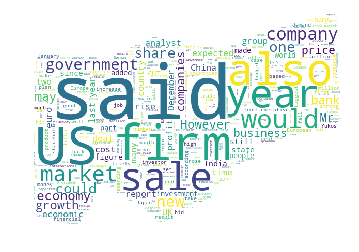

In [5]:
maskImageArray = np.array(Image.open("wordcloud_masks/business.png"))
stop_words = nltk.corpus.stopwords.words('english')
buisness_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'business']['Content'].tolist()))
plt.imshow(buisness_wordcloud)
plt.axis('off')
plt.show()

### Entertainment articles

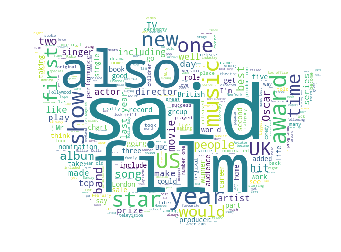

In [6]:
maskImageArray = np.array(Image.open("wordcloud_masks/entairtenment.png"))
stop_words = nltk.corpus.stopwords.words('english')
ent_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'entertainment']['Content'].tolist()))
plt.imshow(ent_wordcloud)
plt.axis('off')
plt.show()

### Politics articles


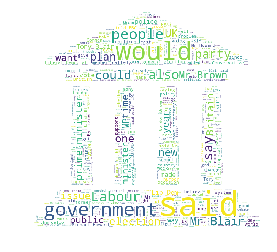

In [7]:
maskImageArray = np.array(Image.open("wordcloud_masks/politics.png"))
stop_words = nltk.corpus.stopwords.words('english')
pol_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'politics']['Content'].tolist()))
plt.imshow(pol_wordcloud)
plt.axis('off')
plt.show()

### Sports articles

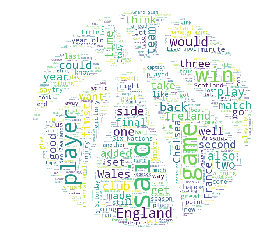

In [8]:
maskImageArray = np.array(Image.open("wordcloud_masks/sports.png"))
stop_words = nltk.corpus.stopwords.words('english')
sport_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'sport']['Content'].tolist()))
plt.imshow(sport_wordcloud)
plt.axis('off')
plt.show()

### Tech articles

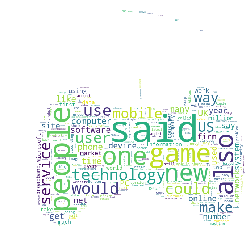

In [9]:
maskImageArray = np.array(Image.open("wordcloud_masks/tech.png"))
stop_words = nltk.corpus.stopwords.words('english')
tech_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'tech']['Content'].tolist()))
plt.imshow(tech_wordcloud)
plt.axis('off')
plt.show()

## 2. Classification 

### Data Preprocessing

Firstly, we have to preprocess our training and test set. We have to consider preprocessing on both title and content columns in order to have homogenous preprocessed data.

In [10]:
 def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove all special characters, punctuation and spaces from string
    text = re.sub(r'\W+',' ', text)
    # remove stop words
    removed = remove_stopwords(text)
    text = "".join(removed)
    # Perform lemamatization
    lemmatizer = WordNetLemmatizer()
    lem_sentence = []
    token_words = word_tokenize(text)
    lem_sentence = [lemmatizer.lemmatize(word) for word in token_words]
    text = " ".join(lem_sentence)
    # return normalized text
    return text

In [11]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.Title = vfunc(input_df.Title.values)
    input_df.Content = vfunc(input_df.Content.values)
    # return processed input_df
    return input_df

Let's apply the above preprocessing techniques on training set

In [12]:
preprocessed_train_df = preprocess(train_df)
preprocessed_train_df.head()

,Id,Title,Content,Category
0,1829,game maker fight survival,britain s largest independent game maker argon...,tech
1,995,chelsea denied james heroic,brave defensive display led keeper david james...,sport
2,858,healthsouth ex bos go trial,head medical service firm healthsouth overstat...,business
3,359,u2 star enter rock hall fame,singer bruce springsteen inducted irish rock b...,entertainment
4,746,amex share spin news,share american express surged 8 tuesday said s...,business


Let's apply now the above preprocessing techniques on test set

In [13]:
preprocessed_test_df = preprocess(test_df)
preprocessed_test_df.head()

,Id,Title,Content,Category
0,233,hobbit picture year away,lord ring director peter jackson said year sta...,entertainment
1,1385,robinson answer critic,england captain jason robinson rubbished sugge...,sport
2,1459,ukip outspent labour eu poll,uk independence party outspent labour liberal ...,politics
3,464,brazil approves bankruptcy reform,major reform brazil s bankruptcy law approved ...,business
4,89,south bank award honour hit soap,coronation street soap triumph south bank awar...,entertainment


## Base Classifier 

Below, we introduce a base classifier class which will be used from each classifier in order to inherit the steps of prediction pipeline. Also, kfold cross-validation is implemented there in an an abstract logic as well.

In [14]:
class Classifier:
    def __init__(self, classifier_name, train_df, test_df, feature):
        self.classifier_name = classifier_name
        self.feature = feature
        self.steps = []
        # Encode labels with value the different articles' categories
        self.le = LabelEncoder()
        self.le.fit(train_df['Category'])
        # define x_train and y_train
        self.x_train = train_df['Content']
        self.y_train = self.le.transform(train_df['Category'])
        # define x_test
        self.x_test = test_df['Content'] if not test_df is None else None
        self.test_ids = test_df['Id'] if not test_df is None else None

    def define_features(self):
        if self.feature == "TF-IDF":
            self.steps.append(('tf-idf', TfidfTransformer()))
        elif self.feature == "BoW":
            self.steps.append(('vect', CountVectorizer(stop_words='english')))            
        return self.steps

    def predict_kfold(self, pipeline):
        score_array = []
        accuracy_array = []
        # apply 10-fold cross validation
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(self.x_train):
            # use iloc which is label based indexing
            cv_train_x = self.x_train.iloc[train_index]
            cv_test_x = self.x_train.iloc[test_index]
            cv_train_y = self.y_train[train_index]
            cv_test_y = self.y_train[test_index]
            # fit model
            pipeline.fit(cv_train_x, cv_train_y)
            if (self.classifier_name == "SVM"):
                print("Best parameters set found on development set:")
                print()
                print(pipeline.named_steps['clf'].best_params_)
                print()
                print("Grid scores on development set:")
                print()
                means = pipeline.named_steps['clf'].cv_results_['mean_test_score']
                stds = pipeline.named_steps['clf'].cv_results_['std_test_score']
                for mean, std, params in zip(means, stds, pipeline.named_steps['clf'].cv_results_['params']):
                    print("%0.3f (+/-%0.03f) for %r"
                          % (mean, std * 2, params))
                print()
            # predict label in form of numbers {0,1,2,3,4}
            predicted = pipeline.predict(cv_test_x)
            # apply inverse transform to get labels
            y_labels = self.le.inverse_transform(cv_test_y)
            y_pred = self.le.inverse_transform(predicted)
            # append score and accuracy values to corresponding arrays
            score_array.append(precision_recall_fscore_support(y_labels, y_pred, average=None))
            accuracy_array.append(accuracy_score(y_labels, y_pred))
        # compute classification report metrics
        avg_accuracy = round(np.mean(accuracy_array), 4)
        avg_scores = np.mean(np.mean(score_array, axis=0), axis=1)
        avg_precision = round(avg_scores[0], 4)
        avg_recall = round(avg_scores[1], 4)
        avg_f1 = round(avg_scores[2], 4)
        return (avg_accuracy, avg_precision, avg_recall, avg_f1)

### Support Vector Machine (SVM)

In [15]:
class SVM(Classifier):
    def __init__(self, train_df, test_df, feature):
        self.tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
        Classifier.__init__(self, "SVM", train_df, test_df, feature)

    def define_features(self):
        steps = Classifier.define_features(self)
        steps.append(('clf', GridSearchCV(SVC(), self.tuned_parameters)))
        self.pipeline = Pipeline(steps)

    def run_kfold(self):
        self.define_features()
        return self.predict_kfold(self.pipeline)

#### Bag of Words featurization method

In [16]:
classifier = SVM(preprocessed_train_df, preprocessed_test_df, "BoW")

In [17]:
scores = classifier.run_kfold()

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.949 (+/-0.003) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.737 (+/-0.016) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.963 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.958 (+/-0.007) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.963 (+/-0.004) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.967 (+/-0.002) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.963 (+/-0.004) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.968 (+/-0.003) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.968 (+/-0.003) for {'C': 1, 'kernel': 'linear'}
0.968 (+/-0.003) for {'C': 10, 'kernel': 'linear'}
0.968 (+/-0.003) for {'C': 100, 'kernel': 'linear'}
0.968 (+/-0.003) for {'C': 1000, 'kernel': 'linear'}

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.950 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel

In [18]:
print(scores)

(0.9696, 0.9698, 0.9699, 0.9693)
